In [54]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter("ignore", category=FutureWarning)

In [55]:
#Import all necessary libraries
import glob
import pandas as pd
import numpy as np

from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import fastparquet
import pyLDAvis
import pyLDAvis.gensim
import warnings
import _pickle as pickle

import re
import random
import collections
import seaborn as sns

from gensim import corpora, models
import gensim
import pyLDAvis.gensim

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy import stats

pyLDAvis.enable_notebook()
random.seed(1234)

from sklearn.metrics.cluster import adjusted_rand_score
pd.options.display.max_columns = None

# 1. Topic Model on CommonCrawl


## 1.1. Loading and Filtering the Data
There are 28 files with ~2500 records each. 

In [56]:
%%time
#Load the parquet files into a single dataframe

result = pd.DataFrame()
#for filename in os.listdir("C:\\tmp\\my.tar\\istjoscha_cc_warc_wat_wet_acht_lang"):
for pth in sorted(glob.glob("data/CC/*")):
    ds = pd.read_parquet(pth)
    #print(pth)
    #print(ds.shape)
    result = result.append(ds)
    #print(result.shape)

#In case you are running out of memory, try to run the filter in the following paragraph on ds before appending

CPU times: user 25.1 s, sys: 14.6 s, total: 39.7 s
Wall time: 41.1 s


In [57]:
#filter on English and university-related content
result = result.loc[(result['Guessed-Language']=='en') & (result['Plaintext'].str.contains("niversity"))]

## 1.2 Constructing the Corpus and Building the Model

In [58]:
#auxiliary function for "straight-forward" natural language preprocessing

def cleanup_text(record):
    text = record['Plaintext']
    # Remove newlines
    text = text.replace(r'\n', ' ')
    words = text.split()

    # Default list of Stopwords
    stopwords_core = ['a', u'about', u'above', u'after', u'again', u'against', u'all', u'am', u'an', u'and', u'any',
                      u'are', u'arent', u'as', u'at',
                      u'be', u'because', u'been', u'before', u'being', u'below', u'between', u'both', u'but', u'by',
                      u'can', 'cant', 'come', u'could', 'couldnt',
                      u'd', u'did', u'didn', u'do', u'does', u'doesnt', u'doing', u'dont', u'down', u'during',
                      u'each',
                      u'few', 'finally', u'for', u'from', u'further',
                      u'had', u'hadnt', u'has', u'hasnt', u'have', u'havent', u'having', u'he', u'her', u'here',
                      u'hers', u'herself', u'him', u'himself', u'his', u'how',
                      u'i', u'if', u'in', u'into', u'is', u'isnt', u'it', u'its', u'itself',
                      u'just',
                      u'll',
                      u'm', u'me', u'might', u'more', u'most', u'must', u'my', u'myself',
                      u'no', u'nor', u'not', u'now',
                      u'o', u'of', u'off', u'on', u'once', u'only', u'or', u'other', u'our', u'ours', u'ourselves',
                      u'out', u'over', u'own',
                      u'r', u're',
                      u's', 'said', u'same', u'she', u'should', u'shouldnt', u'so', u'some', u'such',
                      u't', u'than', u'that', 'thats', u'the', u'their', u'theirs', u'them', u'themselves', u'then',
                      u'there', u'these', u'they', u'this', u'those', u'through', u'to', u'too',
                      u'under', u'until', u'up',
                      u'very',
                      u'was', u'wasnt', u'we', u'were', u'werent', u'what', u'when', u'where', u'which', u'while',
                      u'who', u'whom', u'why', u'will', u'with', u'wont', u'would',
                      u'y', u'you', u'your', u'yours', u'yourself', u'yourselves']

    # Custom List of Stopwords - Add your own here
    stopwords_custom = ['']
    stopwords = stopwords_core + stopwords_custom
    stopwords = [word.lower() for word in stopwords]

    text_out = [re.sub('[^a-zA-Z0-9]', '', word) for word in words]  # Remove special characters
    text_out = [word.lower() for word in text_out if
                len(word) > 2 and word.lower() not in stopwords]  # Remove stopwords and words under X length
    return text_out


In [59]:
%%time
#build gensim corpus

result=result.reset_index()
texts=[]
for index, row in result.iterrows():
    texts.append(cleanup_text(row))

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=10, no_above=0.4)
dictionary.compactify()
corpus = [dictionary.doc2bow(text) for text in texts]

CPU times: user 19.8 s, sys: 2.67 s, total: 22.5 s
Wall time: 22.6 s


In [60]:
%%time
ldamodelnormal = gensim.models.ldamodel.LdaModel(corpus, num_topics=15, id2word = dictionary, passes=10, chunksize=100, update_every=0, alpha=1/15, random_state=1)


CPU times: user 3min 17s, sys: 849 ms, total: 3min 18s
Wall time: 33.2 s


## 1.3 Inspecting the Results

In [121]:
# helper to create descriptive tables (doc-topic probabilities) and visualizations for LDA models 
def getModelResults(ldamodel, corpus, dictionary):
    vis = pyLDAvis.gensim.prepare(ldamodel,corpus, dictionary, sort_topics=False)
    transformed = ldamodel.get_document_topics(corpus)
    df = pd.DataFrame.from_records([{v:k for v, k in row} for row in transformed])
    return vis, df    

In [62]:
# get the top topic per document into a list
def maxTop(x):
    mx = max(x,key=lambda item:item[1])
    if (mx[1]>0.0):
        return(mx[0])
    else:
        return 99

In [63]:
%%time
# get descriptive stuff for all models
normalv, dfnormal = getModelResults(ldamodelnormal, corpus, dictionary)


CPU times: user 41.5 s, sys: 2.43 s, total: 44 s
Wall time: 3min 24s


In [64]:
#print regular topics (top word probabilities)
ldamodelnormal.print_topics(num_words=8)

[(0,
  '0.005*"source" + 0.005*"research" + 0.005*"data" + 0.004*"care" + 0.004*"college" + 0.004*"authors" + 0.004*"presentation" + 0.004*"journal"'),
 (1,
  '0.015*"download" + 0.005*"thin" + 0.004*"films" + 0.004*"magnetic" + 0.003*"research" + 0.003*"book" + 0.003*"film" + 0.003*"international"'),
 (2,
  '0.009*"june" + 0.009*"july" + 0.009*"2017" + 0.007*"february" + 0.007*"january" + 0.007*"march" + 0.007*"october" + 0.007*"september"'),
 (3,
  '0.004*"people" + 0.003*"business" + 0.003*"best" + 0.003*"life" + 0.002*"free" + 0.002*"make" + 0.002*"day" + 0.002*"back"'),
 (4,
  '0.010*"school" + 0.010*"college" + 0.008*"ago" + 0.005*"state" + 0.004*"high" + 0.004*"elementary" + 0.004*"years" + 0.003*"day"'),
 (5,
  '0.003*"free" + 0.003*"design" + 0.003*"data" + 0.002*"share" + 0.002*"2017" + 0.002*"years" + 0.002*"dad" + 0.002*"download"'),
 (6,
  '0.036*"architects" + 0.012*"health" + 0.009*"public" + 0.007*"name" + 0.006*"english" + 0.004*"form" + 0.004*"board" + 0.003*"city"'),

---

# <span style="color:green">Teil 1</span>
## <span style="color:green">Aufgabe 1: Für welche Topics können Sie intuitiv Überbegriffe bilden? Notieren Sie sich diese bzw. legen Sie eine entsprechende „lookup-tabelle“ als Datenstruktur an. Welche Topics erscheinen sinnvoll, welche nicht?</span>

In [104]:
topics = {
    0: 'Research', 
    1: 'Misc',
    2: 'Month',
    3: 'Life',
    4: 'Education', 
    5: 'Medicine',
    6: 'Architect', 
    7: 'Adult', 
    8: 'Country', 
    9: 'Education', 
    10: 'Month', 
    11: 'Technology',
    12: 'Misc',
    13: 'Government',
    14: 'Temperature'
}

---

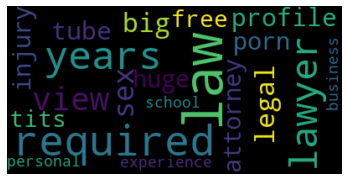

Adult Topic Id = 7


In [66]:
# create a wordcloud for topic: adult content

# get the top topic for a known adult content document 
docTopTopics = [maxTop(x) for x in ldamodelnormal.get_document_topics(corpus)]
adultTopicId = docTopTopics[15]

#gather most relevant terms for the given topic
topics_terms = ldamodelnormal.state.get_lambda()
tmpDict = {}
for i in range(1, len(topics_terms[0])):
    tmpDict[ldamodelnormal.id2word[i]]=topics_terms[adultTopicId,i]

# draw the wordcloud
wordcloud = WordCloud( margin=0,max_words=20 ).generate_from_frequencies(tmpDict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
print("Adult Topic Id = " + str(adultTopicId))

In [67]:
# inspect regular topics - ATTENTION: ALL TOPICS ARE SHIFTED WITH ID +1 w.r.t. GENSIM
normalv

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.022398  0.057067  1       1        4.093208 
1     -0.062898 -0.003101  2       1        8.271789 
2      0.038283 -0.027314  3       1        7.652359 
3      0.037484 -0.035702  4       1        13.628202
4      0.083631  0.021533  5       1        8.952338 
5     -0.014266  0.005649  6       1        2.926609 
6      0.010160 -0.040610  7       1        3.928503 
7      0.024614 -0.022245  8       1        3.311718 
8      0.034279 -0.025834  9       1        4.041581 
9     -0.153347 -0.015513  10      1        14.698672
10     0.024196  0.086517  11      1        5.715767 
11    -0.087725 -0.018147  12      1        4.187424 
12     0.057951 -0.059305  13      1        5.664464 
13     0.017450 -0.000846  14      1        10.992838
14     0.012587  0.077852  15      1        1.934537 , topic_info=      Category         Freq        Term        Total  loglift  logprob
11676  Default  5185.000000  architects  5185.000000  30.0000  30.0000
10371  Default  3828.000000  temp        3828.000000  29.0000  29.0000
9200   Default  2300.000000  max         2300.000000  28.0000  28.0000
528    Default  2281.000000  min         2281.000000  27.0000  27.0000
281    Default  6012.000000  download    6012.000000  26.0000  26.0000
...        ...          ...       ...            ...      ...      ...
1526   Topic15  159.030579   care        3200.542480  0.9433  -5.9732 
1209   Topic15  102.816711   floor       500.858612   2.3619  -6.4093 
1792   Topic15  111.775703   million     1085.342773  1.6721  -6.3258 
875    Topic15  122.748451   view        4462.501953  0.3520  -6.2322 
849    Topic15  114.761383   two         4218.251953  0.3410  -6.2994 

[1153 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
12427  1      0.010907  039 
12427  2      0.643525  039 
12427  3      0.010907  039 
12427  4      0.032722  039 
12427  5      0.010907  039 
...   ..           ...  ... 
2044   11     0.030291  york
2044   12     0.012039  york
2044   13     0.067183  york
2044   14     0.055922  york
2044   15     0.020194  york

[12165 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [90]:
#inspect first 20 documents and their topic distributions
pd.set_option('display.max_colwidth', -1)
pd.concat([result['Target-URI'], dfnormal], axis=1).iloc[0:20]

,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
0,https://www.spiedigitallibrary.org/journals/journal-of-biomedical-optics/volume-22/issue-02/027003/Enzyme-functionalized-thin-cladding-long-period-fiber-grating-in-transition/10.1117/1.JBO.22.2.027003.full,0.998102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://redcliffssecondarycareers.com/?page=early-entry,NaN,0.288481,0.036892,0.386014,0.286876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.kink.com/shoot/40316,NaN,NaN,NaN,0.114024,NaN,0.882777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,http://ducknetweb.blogspot.com/2014/09/aarp-creates-new-tablet-for-seniors.html,0.050195,NaN,NaN,NaN,0.102359,NaN,0.828883,0.011493,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.umassmed.edu/cttc/,0.315390,0.021766,NaN,NaN,0.647686,NaN,NaN,NaN,0.013277,NaN,NaN,NaN,NaN,NaN,NaN
5,https://ju.se/en/it-helpdesk/faq---manuals.html,NaN,NaN,NaN,0.550525,NaN,NaN,NaN,0.153637,NaN,0.292672,NaN,NaN,NaN,NaN,NaN
6,https://www.jobs.ac.uk/job/AXS985/research-associate-78443-037/,NaN,0.632498,NaN,0.355282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,http://www.mathdepartment.net/Butte-College-math-department.php,NaN,0.561694,0.437672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,https://collections.ushmm.org/search/catalog/irn1003631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449671,NaN,0.550277,NaN,NaN,NaN,NaN
9,http://mdciedu.com/news/british-masters-in-business-administration-mba-degree-final-applications-being-received-al-khobar-monday-16th-february-2015/,NaN,NaN,0.124480,0.601407,NaN,NaN,0.040913,0.042643,NaN,NaN,NaN,0.188536,NaN,NaN,NaN


---

# <span style="color:green">Teil 1</span>
## <span style="color:green">Aufgabe 2: Filtern Sie für die weiteren Aufgaben die entsprechenden Records aus dem „result“ DataFrame aus, also z.B. alle Dokumente mit einer entsprechenden Topicwahrscheinlichkeit > 50%.</span>

In [91]:
result_new = pd.concat([result['Target-URI'], dfnormal], axis=1)
result_new[result_new[7] > 0.5][:5]

,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
2,https://www.kink.com/shoot/40316,NaN,NaN,NaN,0.114024,NaN,0.882777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,http://parramatta-new-south-wales.australian-business-online.com/beauty-salon/,NaN,NaN,0.137569,NaN,NaN,0.609707,NaN,NaN,NaN,NaN,NaN,0.249628,NaN,NaN,NaN
15,http://xxxxamateur.com/free-porn/on-her-knees.html,NaN,NaN,NaN,NaN,NaN,0.999635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,http://sbdirtysouthsoccer.com/sport/page/2227,NaN,NaN,NaN,NaN,NaN,0.999366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,https://gateway.okhistory.org/ark:/67531/metadc109995/m1/1/zoom/,NaN,0.184528,NaN,NaN,NaN,0.525066,NaN,NaN,NaN,0.27827,NaN,NaN,NaN,NaN,NaN


## <span style="color:green">Aufgabe 3: Schauen Sie sich nun für einige andere Topics stichprobenartig Dokumente an. Passen diese zu den vorher von Ihnen vergebenen Topic-Überbegriffen? Warum bzw. warum nicht?</span>

In [92]:
print("Topic: " + topics[0])
result_new[result_new[0] > 0.4][:5]

Topic: Research


,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
6,https://www.jobs.ac.uk/job/AXS985/research-associate-78443-037/,NaN,0.632498,NaN,0.355282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,http://www.mathdepartment.net/Butte-College-math-department.php,NaN,0.561694,0.437672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,http://www.prepzone.cn/benkelx/10814.html,NaN,0.683325,0.313269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,https://es.coursera.org/instructor/helen-tibbo,NaN,0.402120,NaN,0.152823,0.382187,NaN,NaN,0.060405,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,http://uk.jobrapido.com/Patient-Services-Representative-jobs,NaN,0.921368,NaN,0.076700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
def print_topics(topic_id, topic_prob):
    print("Topic #" + str(topic_id) + ": " + topics[topic_id])
    display(result_new[result_new[topic_id] > topic_prob][:5])

In [114]:
for i in range(len(topics)):
    if (i != 7):
        print_topics(i, 0.4)

Topic #0: Research


,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
6,https://www.jobs.ac.uk/job/AXS985/research-associate-78443-037/,NaN,0.632498,NaN,0.355282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,http://www.mathdepartment.net/Butte-College-math-department.php,NaN,0.561694,0.437672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,http://www.prepzone.cn/benkelx/10814.html,NaN,0.683325,0.313269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,https://es.coursera.org/instructor/helen-tibbo,NaN,0.402120,NaN,0.152823,0.382187,NaN,NaN,0.060405,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,http://uk.jobrapido.com/Patient-Services-Representative-jobs,NaN,0.921368,NaN,0.076700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Topic #1: Misc


,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
18,http://10a.appal.us/7rpga/,NaN,NaN,0.091363,NaN,NaN,NaN,NaN,NaN,NaN,0.906972,NaN,NaN,NaN,NaN,NaN
29,https://www.business-software.com/product/oracle-jd-edwards-enterpriseone/,0.051758,NaN,NaN,NaN,0.047277,NaN,NaN,0.281634,NaN,0.603716,NaN,NaN,NaN,NaN,NaN
42,https://ju.se/en/it-helpdesk/system-management-ju.html,0.026501,0.054427,NaN,0.173686,NaN,NaN,NaN,0.080816,NaN,0.634904,NaN,NaN,NaN,NaN,0.029082
65,http://okdsmuse.com/okdsmuse/scenic_design/Pages/books/download-Global-Accountabilities%3A-Participation%2C-Pluralism%2C-and-Public-Ethics/,NaN,NaN,NaN,NaN,0.211616,NaN,NaN,NaN,NaN,0.707383,0.080325,NaN,NaN,NaN,NaN
66,http://www.williamkent.com/ogale/ogale/Pleadings/ebook/download-Magnetic-Resonance-in-Food-Science---Latest-Developments/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999982,NaN,NaN,NaN,NaN,NaN


Topic #2: Month


,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
3,http://ducknetweb.blogspot.com/2014/09/aarp-creates-new-tablet-for-seniors.html,0.050195,NaN,NaN,NaN,0.102359,NaN,0.828883,0.011493,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,https://acrah.org/category/video/,NaN,NaN,NaN,NaN,0.247092,NaN,0.688564,NaN,NaN,NaN,NaN,NaN,0.055674,NaN,NaN
36,http://www.cmpcp.ac.uk/events/project-workshops/creative-practice-in-contemporary-concert-music/workshop-1-5-september-2011/,0.226173,0.01597,0.041495,NaN,0.023721,NaN,0.412897,0.095578,NaN,0.175981,NaN,NaN,NaN,NaN,NaN
47,http://calnewport.com/blog/2013/04/10/in-choosing-a-job-dont-ask-what-are-you-good-at-ask-instead-what-are-you-willing-to-get-good-at/?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+StudyHacks+%28Study+Hacks%29&utm_content=My+Yahoo,NaN,NaN,NaN,NaN,0.020991,NaN,0.624628,NaN,NaN,NaN,0.353994,NaN,NaN,NaN,NaN
51,http://cooking-in-cashmere.blogspot.com/2013/11/nutella-rolls.html,NaN,NaN,NaN,NaN,NaN,NaN,0.737921,NaN,NaN,NaN,0.260170,NaN,NaN,NaN,NaN


Topic #3: Life


,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
8,https://collections.ushmm.org/search/catalog/irn1003631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449671,NaN,0.550277,NaN,NaN,NaN,NaN
17,https://fromasecretlocation.com/first-intensity-magazine-new-writing/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.075737,0.647499,NaN,0.275387,NaN,NaN
23,http://honr201spring2013.blogspot.com/2013/01/bas-relief-sculpture.html,NaN,NaN,NaN,NaN,NaN,NaN,0.343069,NaN,NaN,0.013896,0.545462,NaN,0.062780,NaN,0.033397
26,https://bounteous.wordpress.com/tag/photography/,NaN,NaN,NaN,NaN,NaN,NaN,0.325548,NaN,NaN,NaN,0.673659,NaN,NaN,NaN,NaN
40,http://voyagesoftheartemis.blogspot.com/2008/02/sex-scene-examples-for-part-ii.html,NaN,NaN,NaN,NaN,NaN,0.052034,0.016930,NaN,NaN,NaN,0.930813,NaN,NaN,NaN,NaN


Topic #4: Education


,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
7,http://www.mathdepartment.net/Butte-College-math-department.php,NaN,0.561694,0.437672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,http://agmaturedatingyroi.localpolitics101.us/christian-single-men-in-fox-lake.html,NaN,NaN,0.512130,0.192265,NaN,NaN,NaN,NaN,NaN,NaN,0.280191,NaN,0.013918,NaN,NaN
14,http://lmmc.ca/en/concert_details.php?concert_id=114,NaN,NaN,0.846600,0.146901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,https://www.620ckrm.com/2017/03/11/regina-cougars-wbb-team-to-play-in-usports-canada-consolation-final/,NaN,NaN,0.976487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020042,NaN
24,http://feathermerchant.com/?category=sports%3Ecollege&id=363&type=golf%20towel,NaN,0.017528,0.716929,NaN,NaN,NaN,NaN,NaN,0.159435,NaN,0.102939,NaN,NaN,NaN,NaN


Topic #5: Medicine


,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
33,https://connect.innovateuk.org/web/accelerating-innovation-in-rail1/article-view?p_p_id=33&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view&p_p_col_id=column-1&p_p_col_count=1&p_r_p_564233524_tag=automatic+train+regulation,NaN,NaN,NaN,0.07008,0.033696,NaN,NaN,0.893344,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,http://www.slidesearchengine.com/slide/teaching-and-learning-practice-the-view-from-both-sides-of-the-fence,0.161094,NaN,NaN,NaN,0.088861,NaN,NaN,0.582233,NaN,0.167209,NaN,NaN,NaN,NaN,NaN
37,https://medical-dictionary.thefreedictionary.com/Kristine+Bonnevie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.996975,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,https://brbl-dl.library.yale.edu/vufind/Record/3522293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.996138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,http://foundationsrevealed.com/index-of-articles/bra-making/bra-making-projects/181-bras-panelled-cups,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.955642,NaN,NaN,0.04386,NaN,NaN,NaN,NaN


Topic #6: Architect


,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
44,https://clinicarazonable.wordpress.com/2017/02/21/mededpublish-de-la-asociacion-para-la-educacion-medica-en-europa/,0.192802,0.152409,NaN,0.112231,NaN,NaN,0.046469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.484069
67,http://interestedamerican.blogspot.com/2008/08/alabama-mccain-leads-obama-by-20-pts.html,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999938
68,http://www.like2do.com/learn?s=Tornado,0.168581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027,NaN,NaN,NaN,NaN,NaN,0.804280
75,http://www.dbusiness.com/Business-Professionals/Other-Professionals/index.php/specialty/Emergency%2BMedicine,NaN,0.127019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031786,0.840159
248,https://www.health-tourism.com/staffperson.aspx?b=379&sp=12600,NaN,0.273026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.285659,NaN,NaN,0.438632


Topic #8: Country


,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
19,http://tehelkapk.blogspot.com/2014/04/shahbaz-sharif-escapes-shoe-attack-in.html?showComment=1398357527212,NaN,NaN,NaN,NaN,0.081397,NaN,0.186399,0.071883,NaN,NaN,NaN,0.632999,0.0264,NaN,NaN
130,https://www.ticketmozo.com/location/35/baltimore-md,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.993636,NaN,NaN,NaN
159,https://malumnalu.blogspot.com/2018/03/chinese-government-provides.html,NaN,NaN,NaN,NaN,0.058358,NaN,0.466493,NaN,NaN,NaN,NaN,0.474083,NaN,NaN,NaN
191,http://www.asiatoday.fr/details.php?id=10999&country=North_Korea,NaN,NaN,NaN,NaN,0.134112,NaN,NaN,NaN,NaN,NaN,NaN,0.865867,NaN,NaN,NaN
197,https://www.internationalstudent.com/contest/2013/play/Great+Unknown/,NaN,NaN,0.143324,0.173319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.682662,NaN,NaN,NaN


Topic #9: Education


,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
0,https://www.spiedigitallibrary.org/journals/journal-of-biomedical-optics/volume-22/issue-02/027003/Enzyme-functionalized-thin-cladding-long-period-fiber-grating-in-transition/10.1117/1.JBO.22.2.027003.full,0.998102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,http://gistinfo.org/gist-cancer-advisors/research/,0.878516,NaN,0.041175,0.027041,0.051642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,https://openi.nlm.nih.gov/detailedresult.php?img=PMC4581423_40168_2015_104_Fig3_HTML&req=4,0.999103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,http://docplayer.net/24675171-Prescribing-information-ativan-lorazepam-oral-tablets-0-5-mg-1-mg-2-mg-sublingual-tablets-0-5-mg-1-mg-2-mg-anxiolytic-sedative.html,0.999813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,https://worldwidescience.org/topicpages/s/series+linear+accelerators.html,0.999977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Topic #10: Month


,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
5,https://ju.se/en/it-helpdesk/faq---manuals.html,NaN,NaN,NaN,0.550525,NaN,NaN,NaN,0.153637,NaN,0.292672,NaN,NaN,NaN,NaN,NaN
9,http://mdciedu.com/news/british-masters-in-business-administration-mba-degree-final-applications-being-received-al-khobar-monday-16th-february-2015/,NaN,NaN,0.12448,0.601407,NaN,NaN,0.040913,0.042643,NaN,NaN,NaN,0.188536,NaN,NaN,NaN
20,http://www.splitsbrowser.org.uk/EventSwitchBoard.php?eventId=10372,NaN,NaN,NaN,0.999951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,https://www.oxfam.org.uk/fashion-blog/tag/whiteleys,NaN,NaN,NaN,0.781637,NaN,NaN,0.216439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,http://windowoneurasia.blogspot.com/2010/04/window-on-eurasia-russians-wonder-about.html,NaN,NaN,NaN,0.999398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Topic #11: Technology


,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
8,https://collections.ushmm.org/search/catalog/irn1003631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449671,NaN,0.550277,NaN,NaN,NaN,NaN
95,https://my.archdaily.com/us/@harry-2/folders/innovation,NaN,NaN,0.026888,NaN,NaN,NaN,NaN,NaN,0.949375,NaN,NaN,NaN,NaN,NaN,0.022770
96,http://30mileriver.org/programs/water-quality-monitoring/,0.097342,NaN,0.077106,NaN,NaN,NaN,NaN,NaN,0.695536,NaN,0.010793,NaN,0.012128,0.012182,0.094168
161,http://umaec.umich.edu/projects/major-projects/robotics-laboratory/,0.090331,NaN,NaN,0.393033,NaN,NaN,NaN,NaN,0.512650,NaN,NaN,NaN,NaN,NaN,NaN
212,http://bengals-game.us/?p=756,NaN,NaN,NaN,NaN,NaN,NaN,0.096484,NaN,0.842308,0.059626,NaN,NaN,NaN,NaN,NaN


Topic #12: Misc


,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
54,https://perryjgreenbaum.blogspot.com/2012/12/marxs-ecology-oxymoron.html,NaN,NaN,NaN,NaN,0.215160,NaN,0.100741,NaN,NaN,NaN,0.017321,NaN,0.659346,NaN,NaN
59,http://www.theguitarcolumn.com/2012/11/,NaN,NaN,NaN,NaN,NaN,NaN,0.339158,NaN,NaN,NaN,0.217290,NaN,0.442948,NaN,NaN
63,http://wantsun.blogspot.com/2014/10/tony-farrell-urgent-alert-and-message.html,NaN,NaN,NaN,NaN,0.085857,NaN,NaN,NaN,0.024709,NaN,0.018168,NaN,0.868107,NaN,NaN
78,https://stylecourt.blogspot.com/2013/05/petal-to-metal.html,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999690,NaN,NaN
80,https://stylecourt.blogspot.com/2012/11/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999797,NaN,NaN


Topic #13: Government


,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
4,https://www.umassmed.edu/cttc/,0.315390,0.021766,NaN,NaN,0.647686,NaN,NaN,NaN,0.013277,NaN,NaN,NaN,NaN,NaN,NaN
12,https://kevinleavellmt.fbfsagents.com/LearningCenterArticles/LearningCenterArticleByUrl?events=how-to-find-the-best-places-on-airbnb,NaN,0.129434,NaN,NaN,0.482296,NaN,NaN,NaN,NaN,NaN,0.363288,NaN,NaN,0.023504,NaN
13,http://nursamad.blogspot.com/2008/06/,NaN,NaN,NaN,NaN,0.539376,NaN,0.296691,NaN,NaN,NaN,0.163716,NaN,NaN,NaN,NaN
61,https://ideas.repec.org/f/pgo248.html,NaN,NaN,NaN,NaN,0.999866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,https://drchiragjain.blogspot.com/2018/,0.034319,NaN,NaN,NaN,0.575255,NaN,0.100829,NaN,NaN,NaN,0.262597,NaN,0.024718,NaN,NaN


Topic #14: Temperature


,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
43,https://www.earlyshares.com/projects/philadelphia-suburban-residential-rental-fund-1-llc,NaN,NaN,NaN,NaN,0.128418,0.016345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.855034,NaN
118,https://ch.ubchomes.ca/recip.html/510028.search/SearchResults.form,NaN,0.048373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.949881,NaN
147,http://allisonpanter.liveurbandenver.com/about-me.php,NaN,NaN,0.098184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.320200,NaN,NaN,0.580182,NaN
163,https://www.onerealtyhomes.com/guide/pickerington/,NaN,0.014075,0.426670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.088902,NaN,NaN,0.468118,NaN
215,http://sgodbey.russellrealty.com/areas/Valley_View,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.144190,0.058008,NaN,0.442134,0.352319


## <span style="color:green">Aufgabe 4: Formulieren Sie Anfragen zu bestimmten Topic-Mischungen (z.B. Topic A > 40% und Topic B > 40%). Passen die gematchten Dokumente zu Ihren Erwartungen? Warum bzw. warum nicht?</span>

In [116]:
print(topics[0], " AND ", topics[4])
result_new[(result_new[0] > 0.4) &  (result_new[4] > 0.4)][:5]

Research  AND  Education


,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
7,http://www.mathdepartment.net/Butte-College-math-department.php,NaN,0.561694,0.437672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2575,http://sain.scaa.sk.ca/collections/informationobject/browse?subjects=43613&names=52314&places=45665&showAdvanced=1&topLod=0&sort=alphabetic,NaN,0.469248,0.487206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.041903
2685,https://www.indeed.com/q-Number-5-jobs.html,NaN,0.479374,0.447367,NaN,0.017018,NaN,NaN,0.047986,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## <span style="color:green">Aufgabe 5: Berechnen Sie zwei neue Modelle (auf dem Original-Corpus mit Adult-Content) mit verändertem Glättungsparameter für die Dokument-Topic Zuordnungen. Die restlichen Parameter sollen beibehalten werden. Berechnen Sie ein Modell mit Glättungsparameter=1 und ein Modell mit Glättungsparameter=10^-18. Schauen Sie sich wieder jeweils die ersten 20 Zeilen der Dokument-Topic Wahrscheinlichkeitsmatrizen an. Plotten Sie weiterhin die Häufigkeitsverteilungen der „Nicht-NaN-Topics“ pro Dokument.</span>

In [164]:
def plot_notna_values(df_notna):
    df_notna= dfnormal.notna().sum() 
    df_notna = pd.DataFrame(df_notna)
    df_notna.reset_index(inplace=True)
    df_notna.columns = ["topic", "number"]
    sns.barplot(x="topic", y="number",data=df_notna).set_title('notna-frequency')

### <span style="color:green">Glättungsparameter (alpha) = 1</span>

In [161]:
ldamodelnormal = gensim.models.ldamodel.LdaModel(corpus, num_topics=15, id2word = dictionary, passes=10, chunksize=100, update_every=0, alpha=1, random_state=1)
normalv, dfnormal = getModelResults(ldamodelnormal, corpus, dictionary)

In [163]:
dfnormal = dfnormal.sort_index(axis=1)
dfnormal[:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.978410,NaN,NaN,NaN,NaN,NaN
1,0.612489,NaN,NaN,0.011433,0.039805,NaN,NaN,NaN,NaN,0.011255,0.231084,NaN,NaN,0.037204,NaN
2,NaN,NaN,0.027064,NaN,0.071777,NaN,NaN,0.717692,NaN,NaN,0.134602,NaN,0.010009,NaN,NaN
3,NaN,NaN,0.812805,0.038273,NaN,NaN,NaN,NaN,NaN,0.031705,NaN,NaN,NaN,0.080650,NaN
4,0.273124,NaN,NaN,NaN,0.019941,NaN,0.014532,0.015908,NaN,0.273891,0.011843,0.244010,NaN,0.105304,NaN
5,0.520726,0.058231,0.010856,NaN,0.011138,0.091197,NaN,NaN,0.014582,NaN,0.232878,0.010975,NaN,NaN,NaN
6,0.667601,0.021662,0.022043,0.024829,0.021267,0.021437,0.020550,0.019875,0.031905,0.016071,0.060149,0.017644,0.017128,0.020380,0.017460
7,0.664689,NaN,NaN,NaN,0.313372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.997159,NaN,NaN,NaN
9,0.275693,0.013073,0.043015,0.011091,0.074378,0.015649,NaN,NaN,0.170253,NaN,0.339573,NaN,NaN,0.019989,NaN


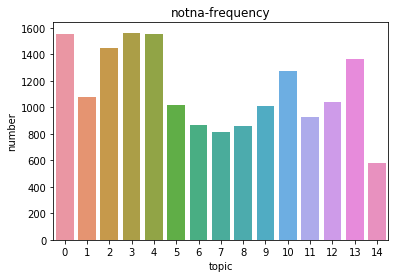

In [165]:
plot_notna_values(dfnormal)

### <span style="color:green">Glättungsparameter (alpha) = 10<sup>-18</sup></span>

In [166]:
ldamodelnormal = gensim.models.ldamodel.LdaModel(corpus, num_topics=15, id2word = dictionary, passes=10, chunksize=100, update_every=0, alpha=10**(-18), random_state=1)
normalv, dfnormal = getModelResults(ldamodelnormal, corpus, dictionary)

In [167]:
dfnormal = dfnormal.sort_index(axis=1)
dfnormal[:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998748,NaN,NaN,NaN,NaN,NaN
1,0.263652,NaN,NaN,NaN,0.032044,NaN,NaN,NaN,NaN,NaN,0.382993,NaN,NaN,0.321311,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.889133,NaN,NaN,0.110867,NaN,NaN,NaN,NaN
3,NaN,NaN,0.829826,NaN,NaN,0.011820,NaN,NaN,NaN,0.050643,NaN,NaN,NaN,0.102955,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.319287,NaN,NaN,NaN,0.679442,NaN
5,NaN,0.304359,NaN,NaN,NaN,0.144564,NaN,NaN,NaN,NaN,0.551077,NaN,NaN,NaN,NaN
6,0.620410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.379590,NaN,NaN,NaN,NaN
7,0.561740,NaN,NaN,NaN,0.438260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,0.694205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.305795,NaN,NaN,NaN
9,NaN,NaN,0.038025,NaN,0.121566,0.039878,NaN,NaN,0.188158,NaN,0.605595,NaN,NaN,NaN,NaN


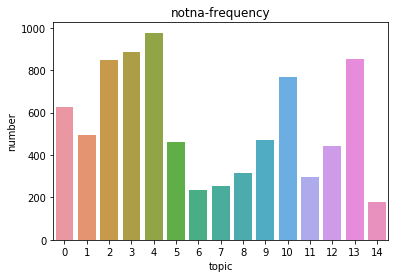

In [168]:
plot_notna_values(dfnormal)

---

# 2. Topic Model on NHTSA (Using HANA Text Analysis Index Table)
## 2.1  Constructing the Corpus (Using HANA Text Analysis Index Table) and Building the Model¶

In [ ]:
#data ingestion and filtering

cmpl = pd.read_csv("data/NHTSA_HANA/cmpl.csv", header=None,  keep_default_na=False)
ta = pd.read_csv("data/NHTSA_HANA/data.csv", header=None,  keep_default_na=False)

ta.columns = ["CMPLID", "TA_RULE","TA_COUNTER","TA_TOKEN","TA_LANGUAGE","TA_TYPE","TA_TYPE_EXPANDED",
              "TA_NORMALIZED" ,"TA_STEM","TA_PARAGRAPH","TA_SENTENCE","TA_CREATED_AT","TA_OFFSET","TA_PARENT" ]
cmpl.columns = ["CMPLID", "ODINO", "MFR_NAME", "MAKETEXT", "MODELTXT", "YEARTXT", "CRASH", "FAILDATE", "FIRE", "INJURED", "DEATHS", "COMPDESC", "CITY", "STATE", "VIN", "DATEA", "LDATE", "MILES", "OCCURRENCES", "CDESCR", "CMPL_TYPE", "POLICE_RPT_VN", "PURCH_DT", "ORIG_OWNER_YN", "ANTI_BRAKES_YN", "CRUISE_CONT_YN", "NUM_CYLS", "DRIVE_TRAIN", "FUEL_SYS", "FUEL_TYPE", "TRANS_TYPE", "VEH_SPEED", "DOT", "TIRE_SIZE", "LOC_OF_TIRE", "TIRE_FAIL_TYPE", "ORIG_EQUIP_YN", "MANUF_DT", "SEAT_TYPE", "RESTRAINT_TYPE", "DEALER_NAME", "DEALER_TEL", "DEALER_CITY", "DEALER_STATE", "DEALER_ZIP", "PROD_TYPE", "REPAIRED_YN", "MEDICAL_ATTN", "VEHICELS_TOWED_YN"]


In [ ]:
#filtering and aggregation

ta = ta[ta.TA_TYPE.isin(['noun', 'adjective']) ]
ta.TA_TOKEN = ta.TA_TOKEN.str.lower()
ta = ta[~ta.TA_TOKEN.isin(['car', 'vehicle']) ] #use as additional stop words
cmpl = cmpl[cmpl.COMPDESC.isin([ 'AIR BAGS','VISIBILITY/WIPER','EXTERIOR LIGHTING','FUEL/PROPULSION SYSTEM', 'SERVICE BRAKES','WHEELS']) ]

ta = ta.merge(cmpl.loc[:,'CMPLID'], on=['CMPLID'], how='inner')
tagrouped = ta.groupby('CMPLID')['TA_TOKEN'].apply(list)

In [ ]:
#show category counts
relevantComplaints = cmpl[cmpl.CMPLID.isin(tagrouped.index.tolist())].sort_values(by=['CMPLID'])
counter=collections.Counter(relevantComplaints.COMPDESC)
print(counter)
print("Anzahl Dokumente: " + str(len(relevantComplaints)))

In [ ]:
#create gensim data structure
nhtsadic = corpora.Dictionary(tagrouped.tolist())
nhtsadic.filter_extremes(no_below=10, no_above=0.4)
nhtsadic.compactify()
nhtsacorpus = [nhtsadic.doc2bow(text) for text in tagrouped]

In [ ]:
%%time

#build topic model and create descriptive stuff
nhtsalda = LdaMulticore(nhtsacorpus, num_topics=10, id2word = nhtsadic, passes=20, alpha=0.0000001, random_state=1)
nhtsavis, dfnhtsa = getModelResults(nhtsalda, nhtsacorpus, nhtsadic)

## 2.2 Inspecting the Results

In [ ]:
nhtsavis